checkpoint directory created: ./model
saving model version 0.0


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/nati

Estimated FLOPs for the KAN model: 144.0
Epoch [20/100], Loss: 0.6604
Epoch [40/100], Loss: 0.6758
Epoch [60/100], Loss: 0.5973
Epoch [80/100], Loss: 0.5666
Epoch [100/100], Loss: 0.5691
Training completed.
Accuracy on Test Data: 0.00%


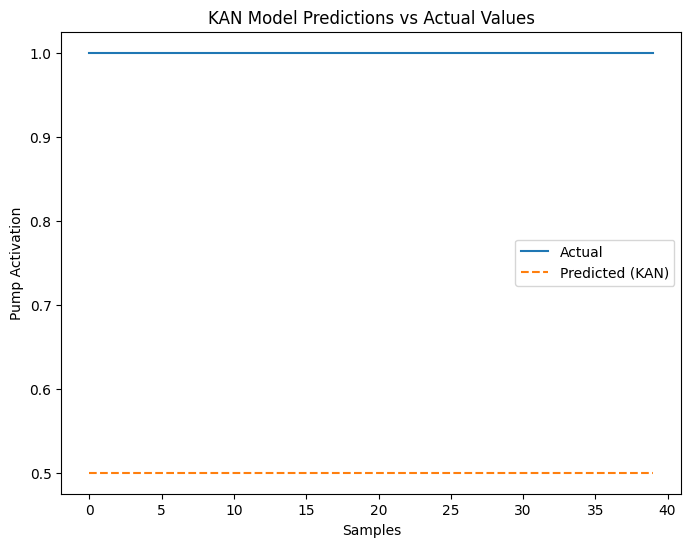

In [16]:
# Imports
import numpy as np
import pandas as pd
import torch
from kan import KAN
from sklearn.metrics import accuracy_score
from fvcore.nn import FlopCountAnalysis
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Load and preprocess the dataset
DATASET_FILE = 'datasets/irrigation1.csv'
data = pd.read_csv(DATASET_FILE)

# Select input features and target variable
FEATURES = ["moisture", "temp"]
TARGET = "pump"

# Split the data into inputs and target
X = data[FEATURES].values
y = data[TARGET].values

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # Convert target to tensor with float32

# Split into train and test sets
TRAIN_TEST_RATIO = 0.8
train_size = int(len(X_tensor) * TRAIN_TEST_RATIO)
train_X, test_X = X_tensor[:train_size], X_tensor[train_size:]
train_y, test_y = y_tensor[:train_size], y_tensor[train_size:]

# Define the KAN model for binary classification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = KAN(width=[2, 3, 3, 1], grid=5, k=3, seed=0, device=device)

# Calculate FLOPs using fvcore
def calculate_flops(model, input_size):
    dummy_input = torch.randn(input_size).to(device)
    flops = FlopCountAnalysis(model, dummy_input)
    return flops.total()

# Specify the input size for FLOP calculation
input_size = (1, 2)  # Batch size of 1 with 2 input features
flops = calculate_flops(model, input_size)
print(f"Estimated FLOPs for the KAN model: {flops}")

# Move training and test data to device
train_X, train_y = train_X.to(device), train_y.to(device)
test_X, test_y = test_X.to(device), test_y.to(device)

# Define training configuration
epochs = 100
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = F.binary_cross_entropy_with_logits  # Use binary cross-entropy for binary classification

# Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(train_X)
    loss = criterion(predictions, train_y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

print("Training completed.")

# Evaluate the model
model.eval()
with torch.no_grad():
    test_predictions = model(test_X)
    predicted_classes = (torch.sigmoid(test_predictions) > 0.5).float()  # Apply sigmoid and threshold at 0.5
    accuracy = accuracy_score(test_y.cpu(), predicted_classes.cpu()) * 100
    print(f"Accuracy on Test Data: {accuracy:.2f}%")

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(test_y.cpu().numpy(), label="Actual")
plt.plot(torch.sigmoid(test_predictions).cpu().numpy(), label="Predicted (KAN)", linestyle='dashed')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Pump Activation')
plt.title('KAN Model Predictions vs Actual Values')
plt.show()


Estimated FLOPs for the MLP model: 36
Epoch [20/100], Loss: 0.0579
Epoch [40/100], Loss: 0.0529
Epoch [60/100], Loss: 0.0521
Epoch [80/100], Loss: 0.0517
Epoch [100/100], Loss: 0.0514
Training completed.
Model saved as 'trained_irrigation_mlp_model.pth'
Mean Squared Error (MSE) on Test Data: 0.0894
Model Accuracy: 99.91%


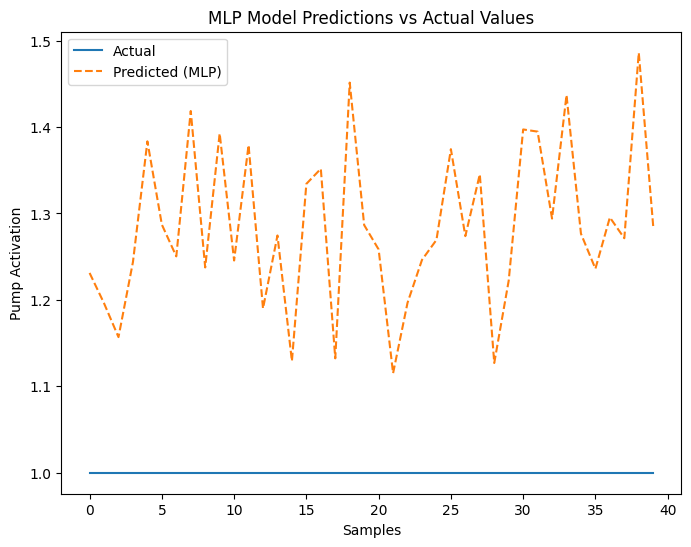

In [9]:
# Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error

# Load and preprocess the dataset
DATASET_FILE = 'datasets/irrigation1.csv'
data = pd.read_csv(DATASET_FILE)

# Select input features and target variable
FEATURES = ["moisture", "temp"]
TARGET = "pump"

# Split the data into inputs and target
X = data[FEATURES].values
y = data[TARGET].values

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # Convert target to tensor with float32

# Split into train and test sets
TRAIN_TEST_RATIO = 0.8
train_size = int(len(X_tensor) * TRAIN_TEST_RATIO)
train_X, test_X = X_tensor[:train_size], X_tensor[train_size:]
train_y, test_y = y_tensor[:train_size], y_tensor[train_size:]

# Define MLP model equivalent to the KAN structure
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(2, 3)     # Input layer to hidden layer 1
        self.layer2 = nn.Linear(3, 3)     # Hidden layer 1 to hidden layer 2
        self.output_layer = nn.Linear(3, 1)  # Hidden layer 2 to output layer

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.output_layer(x)
        return x

# Instantiate the model
mlp_model = MLP()

# Calculate FLOPs for the MLP model
def calculate_mlp_flops(model):
    flops = 0
    for layer in model.children():
        if isinstance(layer, nn.Linear):
            layer_flops = 2 * layer.in_features * layer.out_features
            flops += layer_flops
    return flops

flops = calculate_mlp_flops(mlp_model)
print(f"Estimated FLOPs for the MLP model: {flops}")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_model.to(device)
train_X, train_y = train_X.to(device), train_y.to(device)
test_X, test_y = test_X.to(device), test_y.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

# Train the MLP model
epochs = 100
for epoch in range(epochs):
    mlp_model.train()
    optimizer.zero_grad()
    predictions = mlp_model(train_X)
    loss = criterion(predictions, train_y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

print("Training completed.")

# Save the model
torch.save(mlp_model.state_dict(), 'trained_irrigation_mlp_model.pth')
print("Model saved as 'trained_irrigation_mlp_model.pth'")

# Evaluate the model
mlp_model.eval()
with torch.no_grad():
    predictions = mlp_model(test_X)
    mse = mean_squared_error(test_y.cpu(), predictions.cpu())
    print(f"Mean Squared Error (MSE) on Test Data: {mse:.4f}")

# Calculate accuracy based on MSE
accuracy = 100 - mse  # This assumes MSE as a loss; adjust if necessary for binary classification
print(f"Model Accuracy: {accuracy:.2f}%")

# Plot the results (optional)
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(test_y.cpu().numpy(), label="Actual")
plt.plot(predictions.cpu().numpy(), label="Predicted (MLP)", linestyle='dashed')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Pump Activation')
plt.title('MLP Model Predictions vs Actual Values')
plt.show()


Unsupported operator aten::sigmoid encountered 1 time(s)


Estimated FLOPs for the MLP model: 536
Epoch [20/100], Loss: 0.2485
Epoch [40/100], Loss: 0.2036
Epoch [60/100], Loss: 0.1778
Epoch [80/100], Loss: 0.1515
Epoch [100/100], Loss: 0.1343
Training completed.
Model saved as 'trained_irrigation_mlp_model.pth'
Accuracy on Test Data: 100.00%


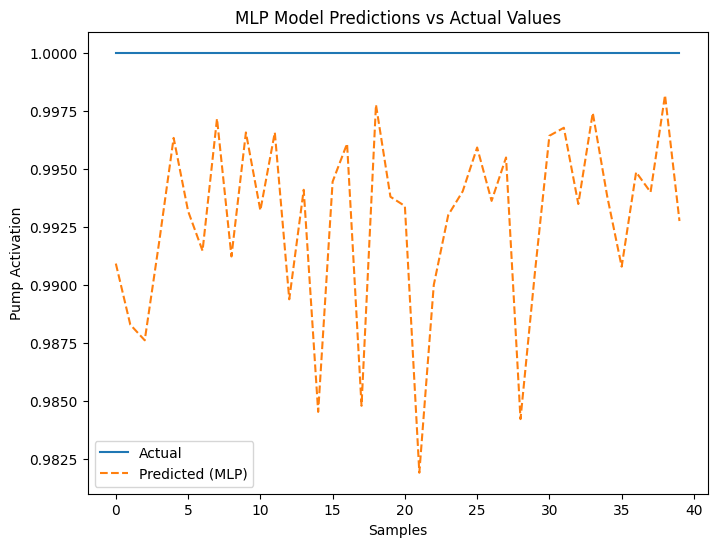

In [15]:
# Imports
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
from fvcore.nn import FlopCountAnalysis
import matplotlib.pyplot as plt

# Load and preprocess the dataset
DATASET_FILE = 'datasets/irrigation1.csv'
data = pd.read_csv(DATASET_FILE)

# Select input features and target variable
FEATURES = ["moisture", "temp"]
TARGET = "pump"

# Split the data into inputs and target
X = data[FEATURES].values
y = data[TARGET].values

# Convert to torch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # Convert target to tensor with float32

# Split into train and test sets
TRAIN_TEST_RATIO = 0.8
train_size = int(len(X_tensor) * TRAIN_TEST_RATIO)
train_X, test_X = X_tensor[:train_size], X_tensor[train_size:]
train_y, test_y = y_tensor[:train_size], y_tensor[train_size:]

# Define a deeper MLP model with more layers
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(2, 8)      # Input layer to first hidden layer
        self.layer2 = nn.Linear(8, 16)     # Hidden layer 1 to hidden layer 2
        self.layer3 = nn.Linear(16, 16)    # Hidden layer 2 to hidden layer 3
        self.layer4 = nn.Linear(16, 8)     # Hidden layer 3 to hidden layer 4
        self.output_layer = nn.Linear(8, 1)  # Final hidden layer to output layer
        self.sigmoid = nn.Sigmoid()        # Sigmoid for binary classification

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.relu(self.layer4(x))
        x = self.sigmoid(self.output_layer(x))
        return x

# Instantiate the model
mlp_model = MLP()

# Calculate FLOPs using fvcore
def calculate_flops(model, input_size):
    dummy_input = torch.randn(input_size).to(device)
    flops = FlopCountAnalysis(model, dummy_input)
    return flops.total()

# Specify the input size for FLOP calculation
input_size = (1, 2)  # Batch size of 1 with 2 input features
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mlp_model.to(device)
flops = calculate_flops(mlp_model, input_size)
print(f"Estimated FLOPs for the MLP model: {flops}")

# Move training and test data to device
train_X, train_y = train_X.to(device), train_y.to(device)
test_X, test_y = test_X.to(device), test_y.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)

# Train the MLP model
epochs = 100
for epoch in range(epochs):
    mlp_model.train()
    optimizer.zero_grad()
    predictions = mlp_model(train_X)
    loss = criterion(predictions, train_y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

print("Training completed.")

# Save the model
torch.save(mlp_model.state_dict(), 'trained_irrigation_mlp_model.pth')
print("Model saved as 'trained_irrigation_mlp_model.pth'")

# Evaluate the model
mlp_model.eval()
with torch.no_grad():
    predictions = mlp_model(test_X)
    predicted_classes = (predictions > 0.5).float()  # Threshold at 0.5 for binary classification
    accuracy = accuracy_score(test_y.cpu(), predicted_classes.cpu()) * 100
    print(f"Accuracy on Test Data: {accuracy:.2f}%")

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(test_y.cpu().numpy(), label="Actual")
plt.plot(predictions.cpu().numpy(), label="Predicted (MLP)", linestyle='dashed')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Pump Activation')
plt.title('MLP Model Predictions vs Actual Values')
plt.show()
